In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import adam
from keras.layers import Dense
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.regularizers import l1






In [2]:
k=pd.read_csv("dataset-HAR-PUC-Rio.csv",delimiter=";")

C:\Users\mairi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
k


In [3]:
df=pd.DataFrame(k,columns=['class'])
df1=pd.DataFrame(k,columns=['gender'])

In [ ]:
df

In [4]:
categorical_movement = {
    'sitting' : 0,
    'sittingdown' : 1,
    'standing' : 2,
    'standingup' : 3,
    'walking' : 4   
}

categorical_gender = {
    'Woman' : 8,
    'Man' : 9
   }
num_cat_mov= df['class'].map(categorical_movement)
num_cat_gen=df1['gender'].map(categorical_gender)
new_df = k.copy()
new_df['num_cat_mov'] = num_cat_mov
new_df['num_cat_gen']=num_cat_gen
new_df['z4'] = pd.to_numeric(new_df['z4'], errors='coerce').fillna(0)
new_df['how_tall_in_meters'] = new_df['how_tall_in_meters'].str.replace(',', '.')
new_df['body_mass_index'] = new_df['body_mass_index'].str.replace(',', '.')


In [6]:
def center(dataframe):
    for column in dataframe.columns[6:18]:
        mean_value = dataframe[column].mean()
        dataframe[column] = dataframe[column] - mean_value
    return dataframe
    

In [5]:
new_order = ['user', 'gender',  'age', 'how_tall_in_meters', 'weight', 'num_cat_gen', 'body_mass_index', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4','z4','class','num_cat_mov']
new_df = new_df.reindex(columns=new_order)

In [ ]:
new_df

In [6]:
target_columns = ['user','gender','class']


j = new_df.drop(target_columns, axis=1)

In [ ]:
#A1 kai A2

X = j.iloc[:, :-1]
y = j.iloc[:, -1]


mse_scores = []
ce_scores = []
acc_scores = []

num_folds = 5

# define the KFold object
kfold = KFold(n_splits=num_folds, shuffle=True)

fold = 0

# loop over each fold
for train_index, test_index in kfold.split(X):
    # split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    
    # define the model architecture
    optimizer = SGD(learning_rate=0.001)
    early_stopping = EarlyStopping(monitor='loss', patience=5)
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['mse', 'sparse_categorical_crossentropy','accuracy'])
    

    
    # fit the model on the train set
    history=model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, callbacks =[early_stopping])
    mse_score = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
    ce_score = model.evaluate(X_test_scaled, y_test, verbose=0)[2]
    acc_score = model.evaluate(X_test_scaled, y_test, verbose=0)[3]
    mse_scores.append(mse_score)
    ce_scores.append(ce_score)
    acc_scores.append(acc_score)


    fold += 1


In [ ]:
print(np.mean(mse_scores))
print(np.mean(ce_scores))
print(np.mean(acc_scores))


In [ ]:
#A3 momentum kai learning rate

X = j.iloc[:, :-1]
y = j.iloc[:, -1]

learning_rates = [0.001, 0.001, 0.05,0.1]
momentums = [0.2, 0.6, 0.6,0.6]

for i in range(len(learning_rates)):
    lr = learning_rates[i]
    momentum = momentums[i]
    
    
    # Compile the model with a new optimizer for each combination of lr and momentum
    model = Sequential()
    model.add(Dense(22, activation='relu', input_dim=17))
    model.add(Dense(5, activation='softmax'))
    sgd = SGD(learning_rate=lr, momentum=momentum)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['mse', 'sparse_categorical_crossentropy','accuracy'])
        
    # Train the model using K-fold cross-validation
    k = 5
    num_epochs = 10
    batch_size = 32
    acc_scores = []
    mse_scores = []
    ce_scores = []
    for train_idx, test_idx in KFold(n_splits=k,shuffle=True).split(X):
        
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
            
        history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_scaled, y_test))
        mse_score = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
        ce_score = model.evaluate(X_test_scaled, y_test, verbose=0)[2]
        acc_score = model.evaluate(X_test_scaled, y_test, verbose=0)[3]
        mse_scores.append(mse_score)
        ce_scores.append(ce_score)
        acc_scores.append(acc_score)
    avg_accuracy = np.mean(acc_scores)
    avg_mse = np.mean(mse_scores)
    avg_ce = np.mean(ce_scores)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning rate: {lr}, Momentum: {momentum}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    # Print the results for each combination of lr and momentum
    print(f"Learning rate: {lr}, Momentum: {momentum}, Accuracy: {avg_accuracy:.4f}, MSE: {avg_mse:.3f}, CE loss: {avg_ce:.4f}")


In [ ]:
#A4 regularization,diff r values


X = j.iloc[:, :-1]
y = j.iloc[:, -1]
reg_params = [0.001,0.05,0.09]  # regularization parameter values to test
lr=0.001
momentum=0.6
for r in reg_params:
    # Compile the model with a new optimizer and regularization for each combination of lr, momentum, and r
    model = Sequential()
    model.add(Dense(22, activation='relu', input_dim=17, kernel_regularizer=l1(r)))
    model.add(Dense(5, activation='softmax'))
    sgd = SGD(learning_rate=lr, momentum=momentum)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['mse', 'sparse_categorical_crossentropy','accuracy'])
        
    # Train the model using K-fold cross-validation
    k = 5
    num_epochs = 10
    batch_size = 32
    acc_scores = []
    mse_scores = []
    ce_scores = []
    for train_idx, test_idx in KFold(n_splits=k, shuffle=True).split(X):
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
            
        history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_scaled, y_test),c)
        mse_score = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
        ce_score = model.evaluate(X_test_scaled, y_test, verbose=0)[2]
        acc_score = model.evaluate(X_test_scaled, y_test, verbose=0)[3]
        mse_scores.append(mse_score)
        ce_scores.append(ce_score)
        acc_scores.append(acc_score)
        
    avg_accuracy = np.mean(acc_scores)
    avg_mse = np.mean(mse_scores)
    avg_ce = np.mean(ce_scores)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning rate: {lr}, Momentum: {momentum}, Regularization: L1 with r={r}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    # Print the results for each combination of lr, momentum, and r
    print(f"Learning rate: {lr}, Momentum: {momentum}, Regularization: L1 with r={r}, Accuracy: {avg_accuracy:.4f}, MSE: {avg_mse:.3f}, CE loss: {avg_ce:.4f}")

Epoch 1/30
4141/4141 [==============================] - 10s 2ms/step - loss: 0.8185 - mse: 5.4224 - sparse_categorical_crossentropy: 0.7198 - accuracy: 0.7696 - val_loss: 0.5568 - val_mse: 5.4316 - val_sparse_categorical_crossentropy: 0.4556 - val_accuracy: 0.8458
Epoch 2/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.4647 - mse: 5.4617 - sparse_categorical_crossentropy: 0.3614 - accuracy: 0.8839 - val_loss: 0.4008 - val_mse: 5.4522 - val_sparse_categorical_crossentropy: 0.2959 - val_accuracy: 0.9122
Epoch 3/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.3612 - mse: 5.4772 - sparse_categorical_crossentropy: 0.2552 - accuracy: 0.9253 - val_loss: 0.3333 - val_mse: 5.4636 - val_sparse_categorical_crossentropy: 0.2264 - val_accuracy: 0.9336
Epoch 4/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.3115 - mse: 5.4856 - sparse_categorical_crossentropy: 0.2042 - accuracy: 0.9413 - val_loss: 0.2964 - val_mse: 5.4690 - val_sparse

Epoch 2/30
4141/4141 [==============================] - 10s 2ms/step - loss: 0.1472 - mse: 5.4955 - sparse_categorical_crossentropy: 0.0706 - accuracy: 0.9817 - val_loss: 0.1420 - val_mse: 5.5332 - val_sparse_categorical_crossentropy: 0.0658 - val_accuracy: 0.9833
Epoch 3/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.1454 - mse: 5.4956 - sparse_categorical_crossentropy: 0.0697 - accuracy: 0.9818 - val_loss: 0.1413 - val_mse: 5.5329 - val_sparse_categorical_crossentropy: 0.0661 - val_accuracy: 0.9839
Epoch 4/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.1438 - mse: 5.4957 - sparse_categorical_crossentropy: 0.0689 - accuracy: 0.9820 - val_loss: 0.1393 - val_mse: 5.5333 - val_sparse_categorical_crossentropy: 0.0649 - val_accuracy: 0.9840
Epoch 5/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.1421 - mse: 5.4958 - sparse_categorical_crossentropy: 0.0682 - accuracy: 0.9822 - val_loss: 0.1382 - val_mse: 5.5333 - val_sparse

Epoch 3/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.1128 - mse: 5.5014 - sparse_categorical_crossentropy: 0.0555 - accuracy: 0.9858 - val_loss: 0.1156 - val_mse: 5.5206 - val_sparse_categorical_crossentropy: 0.0585 - val_accuracy: 0.9844
Epoch 4/30
4141/4141 [==============================] - 12s 3ms/step - loss: 0.1121 - mse: 5.5013 - sparse_categorical_crossentropy: 0.0552 - accuracy: 0.9859 - val_loss: 0.1141 - val_mse: 5.5206 - val_sparse_categorical_crossentropy: 0.0574 - val_accuracy: 0.9855
Epoch 5/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.1115 - mse: 5.5014 - sparse_categorical_crossentropy: 0.0549 - accuracy: 0.9859 - val_loss: 0.1139 - val_mse: 5.5206 - val_sparse_categorical_crossentropy: 0.0576 - val_accuracy: 0.9853
Epoch 6/30
4141/4141 [==============================] - 9s 2ms/step - loss: 0.1110 - mse: 5.5014 - sparse_categorical_crossentropy: 0.0548 - accuracy: 0.9858 - val_loss: 0.1129 - val_mse: 5.5205 - val_sparse

Epoch 4/30
4141/4141 [==============================] - 11s 3ms/step - loss: 0.0986 - mse: 5.5133 - sparse_categorical_crossentropy: 0.0497 - accuracy: 0.9873 - val_loss: 0.0996 - val_mse: 5.4774 - val_sparse_categorical_crossentropy: 0.0508 - val_accuracy: 0.9870
Epoch 5/30
4141/4141 [==============================] - 12s 3ms/step - loss: 0.0982 - mse: 5.5133 - sparse_categorical_crossentropy: 0.0495 - accuracy: 0.9874 - val_loss: 0.0994 - val_mse: 5.4773 - val_sparse_categorical_crossentropy: 0.0508 - val_accuracy: 0.9869
Epoch 6/30
4141/4141 [==============================] - 11s 3ms/step - loss: 0.0979 - mse: 5.5133 - sparse_categorical_crossentropy: 0.0494 - accuracy: 0.9874 - val_loss: 0.0987 - val_mse: 5.4774 - val_sparse_categorical_crossentropy: 0.0503 - val_accuracy: 0.9874
Epoch 7/30
4141/4141 [==============================] - 11s 3ms/step - loss: 0.0975 - mse: 5.5133 - sparse_categorical_crossentropy: 0.0492 - accuracy: 0.9875 - val_loss: 0.0988 - val_mse: 5.4776 - val_spa

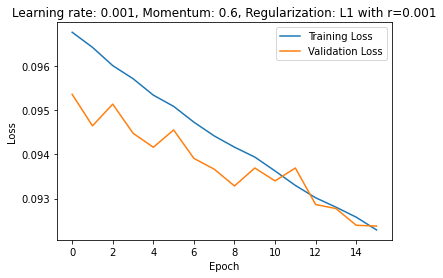

Learning rate: 0.001, Momentum: 0.6, Regularization: L1 with r=0.001, Accuracy: 0.9859, MSE: 5.505, CE loss: 0.0556


In [8]:
#A5 Deep neaural net

X = j.iloc[:, :-1]
y = j.iloc[:, -1]
reg_params = [0.001]  # regularization parameter values to test
lr=0.001
momentum=0.6
for r in reg_params:
    # Compile the model with a new optimizer and regularization for each combination of lr, momentum, and r
    model = Sequential()
    early_stopping = EarlyStopping(monitor='accuracy', patience=3)
    model.add(Dense(100, activation='relu', input_dim=17, kernel_regularizer=l2(r)))
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(r)))
    model.add(Dense(5, activation='softmax'))
    sgd = SGD(learning_rate=lr, momentum=momentum)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['mse', 'sparse_categorical_crossentropy','accuracy'])
        
    # Train the model using K-fold cross-validation
    k = 5
    num_epochs = 30
    batch_size = 32
    acc_scores = []
    mse_scores = []
    ce_scores = []
    for train_idx, test_idx in KFold(n_splits=k, shuffle=True).split(X):
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
            
        history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping])
        mse_score = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
        ce_score = model.evaluate(X_test_scaled, y_test, verbose=0)[2]
        acc_score = model.evaluate(X_test_scaled, y_test, verbose=0)[3]
        mse_scores.append(mse_score)
        ce_scores.append(ce_score)
        acc_scores.append(acc_score)
        
    avg_accuracy = np.mean(acc_scores)
    avg_mse = np.mean(mse_scores)
    avg_ce = np.mean(ce_scores)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning rate: {lr}, Momentum: {momentum}, Regularization: L1 with r={r}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    # Print the results for each combination of lr, momentum, and r
    print(f"Learning rate: {lr}, Momentum: {momentum}, Regularization: L1 with r={r}, Accuracy: {avg_accuracy:.4f}, MSE: {avg_mse:.3f}, CE loss: {avg_ce:.4f}")